# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=17ef4c1c7ec7e7ea6ed88bd701740399abaa810ef73706896b9e627d51b524cd
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
!pip install scikit-learn

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from functools import *
from pyspark.sql.functions import *
from pyspark.sql import DataFrame
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Bucketizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.getOrCreate()

# Check Data

Ta sẽ thực hiện việc kết hợp data đã cho:
- Hợp data properties_2016 với train_2016, properties_2017 với train_2017 dựa vào cột `parcelid`
- Ghép dữ liệu 2 năm 2016 và 2017

In [ ]:
properties_2016 = spark.read.csv('/content/drive/MyDrive/Data/properties_2016.csv', header=True, inferSchema=True)

In [ ]:
train_2016 = spark.read.csv('/content/drive/MyDrive/Data/train_2016_v2.csv', header=True, inferSchema=True)

In [ ]:
train_2016 = train_2016.withColumnRenamed('parcelid', 'parcelid_train')

In [ ]:
df_2016 = properties_2016.join(train_2016, properties_2016['parcelid'] == train_2016['parcelid_train'], 'inner')

In [ ]:
properties_2017 = spark.read.csv('/content/drive/MyDrive/Data/properties_2017.csv', header=True, inferSchema=True)

In [ ]:
train_2017 = spark.read.csv('/content/drive/MyDrive/Data/train_2017.csv', header=True, inferSchema=True)

In [ ]:
train_2017 = train_2017.withColumnRenamed('parcelid', 'parcelid_train')

In [ ]:
df_2017 = properties_2017.join(train_2017, properties_2017['parcelid'] == train_2017['parcelid_train'], 'inner')

In [ ]:
properties_2016.count()

2985217

In [ ]:
train_2016.count()

90275

In [ ]:
properties_2017.count()

2985217

In [ ]:
train_2017.count()

77613

In [ ]:
df_2016.count()

90275

In [ ]:
df_2017.count()

77613

In [ ]:
# Kết hợp 2 data
# def unionAll(*dfs):
#     return reduce(DataFrame.unionAll, dfs)

# def unionAll(dfs):
#     return reduce(lambda df1, df2: df1.union(df2.select(df1.columns), dfs))

# df = unionAll([df_2016, df_2017])

df = df_2016.union(df_2017)

In [ ]:
# Check schema
df.printSchema()

root
 |-- parcelid: integer (nullable = true)
 |-- airconditioningtypeid: integer (nullable = true)
 |-- architecturalstyletypeid: integer (nullable = true)
 |-- basementsqft: integer (nullable = true)
 |-- bathroomcnt: double (nullable = true)
 |-- bedroomcnt: double (nullable = true)
 |-- buildingclasstypeid: integer (nullable = true)
 |-- buildingqualitytypeid: integer (nullable = true)
 |-- calculatedbathnbr: double (nullable = true)
 |-- decktypeid: integer (nullable = true)
 |-- finishedfloor1squarefeet: integer (nullable = true)
 |-- calculatedfinishedsquarefeet: double (nullable = true)
 |-- finishedsquarefeet12: integer (nullable = true)
 |-- finishedsquarefeet13: integer (nullable = true)
 |-- finishedsquarefeet15: integer (nullable = true)
 |-- finishedsquarefeet50: integer (nullable = true)
 |-- finishedsquarefeet6: integer (nullable = true)
 |-- fips: integer (nullable = true)
 |-- fireplacecnt: integer (nullable = true)
 |-- fullbathcnt: integer (nullable = true)
 |-- gar

In [ ]:
# Kiểm tra thống kê mô tả
df.describe().show()

+-------+--------------------+---------------------+------------------------+-----------------+------------------+------------------+-------------------+---------------------+------------------+----------+------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------------+-------------------+------------------+------------------+------------------+---------------------+-------------------+--------------------+------------------+-------+-----------------+------------+-----------+--------------------+-------------------------+---------------------+------------------+----------------------+------------------+------------------+--------------------+-----------------+------------------+-----------+-------------------+----------------------+------------------+------------------+------------------+------------------+------------------+--------------------------+------------------+------

# EDA

<ipython-input-19-15439b4f82bd>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pandas_df)


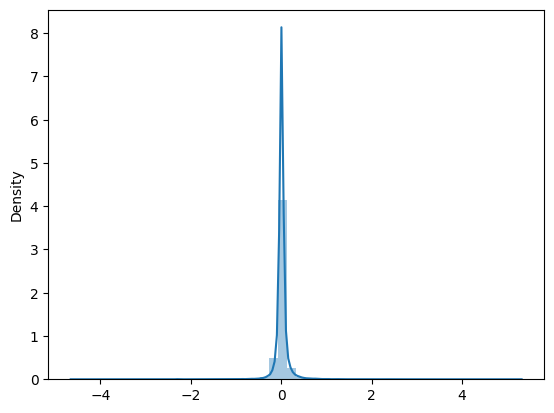

[Row(skewness(logerror)=2.9508442908992385)]


In [ ]:
# Select a single column and sample and convert to pandas
sample_df = df.select(['logerror']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.show()

# Compute and print skewness of logerror
print(df.agg({'logerror': 'skewness'}).collect())

In [ ]:
df.agg({'logerror': 'max'}).collect()

[Row(max(logerror)=5.2629986498)]

In [ ]:
df.agg({'logerror': 'min'}).collect()

[Row(min(logerror)=-4.65542037764)]

In [ ]:
# calculatedfinished_square = df.select(['calculatedfinishedsquarefeet', 'logerror']).sample(False, 0.5,42)
# calculatedfinished_square = calculatedfinished_square.toPandas()

# sns.lmplot(data=calculatedfinished_square, x='calculatedfinishedsquarefeet', y='logerror')

In [ ]:
# finishedsquare = df.select(['finishedsquarefeet12', 'logerror']).sample(False, 0.5,42)
# finishedsquare = finishedsquare.toPandas()

# sns.lmplot(data=finishedsquare, x='finishedsquarefeet12', y='logerror')

In [ ]:
# df_room = df.select(['roomcnt','logerror']).sample(False, 0.5, 42)
# df_room = df_room.toPandas()

# sns.lmplot(data=df_room, x='roomcnt', y='logerror')

In [ ]:
# df_county = df.select(['regionidcounty']).sample(False, 0.5,42)
# df_county = df_county.toPandas()

# sns.countplot(data=df_county, x='regionidcounty')
# plt.show()

In [ ]:
# df_month = df.withColumn('month', month('transactiondate')).select(['month']).sample(False, 0.5,42)
# df_month = df_month.toPandas()

# sns.countplot(data=df_month, x='month')
# plt.show()

In [ ]:
# df_year = df.withColumn('year', year('transactiondate')).select(['year']).sample(False, 0.5,42)
# df_year = df_year.toPandas()

# sns.countplot(data=df_year, x='year')
# plt.show()

In [ ]:
# sample_df = df.select(['structuretaxvaluedollarcnt']).sample(False, 0.5, 42)
# pandas_df = sample_df.toPandas()

# sns.distplot(pandas_df)
# plt.show()

# print(df.agg({'structuretaxvaluedollarcnt': 'skewness'}).collect())

In [ ]:
# sample_df = df.select(['landtaxvaluedollarcnt']).sample(False, 0.5, 42)
# pandas_df = sample_df.toPandas()

# sns.distplot(pandas_df)
# plt.show()

# print(df.agg({'landtaxvaluedollarcnt': 'skewness'}).collect())

In [ ]:
# sample_df = df.select(['taxvaluedollarcnt']).sample(False, 0.5, 42)
# pandas_df = sample_df.toPandas()

# sns.distplot(pandas_df)
# plt.show()

# print(df.agg({'taxvaluedollarcnt': 'skewness'}).collect())

# Clean Data

## Missing values

Ta sẽ loại bỏ các cột bị trống hơn 60% tổng dữ liệu

In [ ]:
# df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()
df.select([(count(when(col(c).isNull(), c))/count(lit(1))).alias(c) for c in df.columns]).show()

+--------+---------------------+------------------------+------------------+--------------------+--------------------+-------------------+---------------------+--------------------+------------------+------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+------------------+--------------------+------------------+------------------+------------------+---------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------------+---------------------+-------------------+----------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+----------------------+------------------+------------------+------------------+--------------------+----------

In [ ]:
print(f'Trước khi lọc dữ liệu có {len(df.columns)} cột.')

Trước khi lọc dữ liệu có 61 cột.


In [ ]:
def column_dropper(df, threshold):
    # Takes a dataframe and threshold for missing values. Returns a dataframe.
    total_records = df.count()
    for col in df.columns:
        # Calculate the percentage of missing values
        missing = df.where(df[col].isNull()).count()
        missing_percent = missing / total_records
        # Drop column if percent of missing is more than threshold
        if missing_percent > threshold:
            df = df.drop(col)
    return df

# Drop columns that are more than 60% missing
df = column_dropper(df, 0.6)

In [ ]:
print(f'Sau khi lọc dữ liệu còn {len(df.columns)} cột.')

Sau khi lọc dữ liệu còn 32 cột.


In [ ]:
df.columns

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'fullbathcnt',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'roomcnt',
 'unitcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'parcelid_train',
 'logerror',
 'transactiondate']

In [ ]:
df.printSchema()

root
 |-- parcelid: integer (nullable = true)
 |-- bathroomcnt: double (nullable = true)
 |-- bedroomcnt: double (nullable = true)
 |-- buildingqualitytypeid: integer (nullable = true)
 |-- calculatedbathnbr: double (nullable = true)
 |-- calculatedfinishedsquarefeet: double (nullable = true)
 |-- finishedsquarefeet12: integer (nullable = true)
 |-- fips: integer (nullable = true)
 |-- fullbathcnt: integer (nullable = true)
 |-- heatingorsystemtypeid: integer (nullable = true)
 |-- latitude: integer (nullable = true)
 |-- longitude: integer (nullable = true)
 |-- lotsizesquarefeet: double (nullable = true)
 |-- propertycountylandusecode: string (nullable = true)
 |-- propertylandusetypeid: integer (nullable = true)
 |-- propertyzoningdesc: string (nullable = true)
 |-- rawcensustractandblock: double (nullable = true)
 |-- regionidcity: integer (nullable = true)
 |-- regionidcounty: integer (nullable = true)
 |-- regionidzip: integer (nullable = true)
 |-- roomcnt: double (nullable = tr

In [ ]:
# Thay thế các giá trị null = 0
df = df.na.fill(0)

In [ ]:
# Tính giá trị trung bình cột year
year_mean = df.agg({'yearbuilt': 'mean'}).collect()[0][0]
# Thay thế các giá trị trống bằng giá trị mean
df = df.withColumn('yearbuilt', when(df['yearbuilt'] == 0, year_mean).otherwise(df['yearbuilt']))

In [ ]:
# Thay các giá trị 0 ở cột heatingorsystemtypeid bằng 13
df = df.withColumn('heatingorsystemtypeid', when(df['heatingorsystemtypeid'] == 0, 13).otherwise(df['heatingorsystemtypeid']))

In [ ]:
# Thay giá trị null ở các cột calculatedfinishedsquarefeet, finishedsquarefeet12, lotsizesquarefeet bằng giá trị mean
temp = df.agg({'calculatedfinishedsquarefeet': 'mean'}).collect()[0][0]
df = df.withColumn('calculatedfinishedsquarefeet', when(df['calculatedfinishedsquarefeet'] == 0, temp).otherwise(df['calculatedfinishedsquarefeet']))

temp = df.agg({'finishedsquarefeet12': 'mean'}).collect()[0][0]
df = df.withColumn('finishedsquarefeet12', when(df['finishedsquarefeet12'] == 0, temp).otherwise(df['finishedsquarefeet12']))

temp = df.agg({'lotsizesquarefeet': 'mean'}).collect()[0][0]
df = df.withColumn('lotsizesquarefeet', when(df['lotsizesquarefeet'] == 0, temp).otherwise(df['lotsizesquarefeet']))

# temp = df.agg({'structuretaxvaluedollarcnt': 'mean'}).collect()[0][0]
# df = df.withColumn('structuretaxvaluedollarcnt', when(df['structuretaxvaluedollarcnt'] == 0, temp).otherwise(df['structuretaxvaluedollarcnt']))

# temp = df.agg({'landtaxvaluedollarcnt': 'mean'}).collect()[0][0]
# df = df.withColumn('landtaxvaluedollarcnt', when(df['landtaxvaluedollarcnt'] == 0, temp).otherwise(df['landtaxvaluedollarcnt']))

# temp = df.agg({'taxvaluedollarcnt': 'mean'}).collect()[0][0]
# df = df.withColumn('taxvaluedollarcnt', when(df['taxvaluedollarcnt'] == 0, temp).otherwise(df['taxvaluedollarcnt']))

# temp = df.agg({'taxamount': 'mean'}).collect()[0][0]
# df = df.withColumn('taxamount', when(df['taxamount'] == 0, temp).otherwise(df['taxamount']))


In [ ]:
cols = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'calculatedfinishedsquarefeet',
        'finishedsquarefeet12','fullbathcnt', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'propertylandusetypeid',
         'roomcnt', 'unitcnt', 'yearbuilt', 'logerror', 'transactiondate']
df_build = df.select(cols)
# 'latitude', 'longitude', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount',
# 'assessmentyear', 'propertyzoningdesc',

## Duplicate

## Outlier filtering

In [ ]:
# cols = ['structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxvaluedollarcnt',
#         'calculatedfinishedsquarefeet', 'finishedsquarefeet12']

# def outlier_filtering(df, cols):
#     for col in cols:
#         mean_val = df.agg({col: 'mean'}).collect()[0][0]
#         stddev_val = df.agg({col: 'stddev'}).collect()[0][0]

#         lower_bound = mean_val - (3 * stddev_val)
#         upper_bound = mean_val + (3 * stddev_val)

#         df = df.filter((df_build[col] > lower_bound) & (df_build[col] < upper_bound))
#     return df

# df_build = outlier_filtering(df_build, cols)

## Text filtering

# Adjust Data

## Robust Scaling

In [ ]:
# cols = ['structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxvaluedollarcnt',
#         'calculatedfinishedsquarefeet', 'finishedsquarefeet12']

# def robust_scaling(df, cols):s
#     for col in cols:
#         q1 = df.approxQuantile(col, [0.25], 0.05)[0]
#         q3 = df.approxQuantile(col, [0.75], 0.05)[0]

#         new_col = 'scaled_' + col
#         df = df.withColumn(new_col, (df[col] - q1) / (q3 - q1))
#     return df

# df_build = robust_scaling(df_build, cols)

# Feature Engineering

## Create new columns

In [ ]:
# Tạo thêm cột năm từ cột transactiondate
df_build = df_build.withColumn('year', year('transactiondate'))

df_build[['transactiondate','year']].show(10)

+---------------+----+
|transactiondate|year|
+---------------+----+
|     2016-01-27|2016|
|     2016-03-30|2016|
|     2016-05-27|2016|
|     2016-06-07|2016|
|     2016-08-08|2016|
|     2016-08-26|2016|
|     2016-07-08|2016|
|     2016-05-11|2016|
|     2016-06-15|2016|
|     2016-05-27|2016|
+---------------+----+
only showing top 10 rows



In [ ]:
# Thêm cột thời gian công trình, trừ các dữ liệu không có năm xây dựng
df_build = df_build.withColumn('age', df_build['year'] - df_build['yearbuilt'])

df_build[['year', 'yearbuilt', 'age']].show(10)

+----+---------+----+
|year|yearbuilt| age|
+----+---------+----+
|2016|   1986.0|30.0|
|2016|   1990.0|26.0|
|2016|   1956.0|60.0|
|2016|   1965.0|51.0|
|2016|   1984.0|32.0|
|2016|   1980.0|36.0|
|2016|   1978.0|38.0|
|2016|   1971.0|45.0|
|2016|   1979.0|37.0|
|2016|   1950.0|66.0|
+----+---------+----+
only showing top 10 rows



In [ ]:
# Thêm cột xem nhà có sử dụng heatingorsystemtypeid hay không
df_build = df_build.withColumn('heating_system', when(df_build['heatingorsystemtypeid'] == 13, 0).otherwise(1))
df_build[['heatingorsystemtypeid', 'heating_system']].show(10)

+---------------------+--------------+
|heatingorsystemtypeid|heating_system|
+---------------------+--------------+
|                   13|             0|
|                   13|             0|
|                   13|             0|
|                   13|             0|
|                   13|             0|
|                   13|             0|
|                   13|             0|
|                   13|             0|
|                   13|             0|
|                   13|             0|
+---------------------+--------------+
only showing top 10 rows



In [ ]:
# Thêm cột sai số trong việc tính toán diện tích nhà
df_build = df_build.withColumn('error_livingarea', df_build['calculatedfinishedsquarefeet']/df_build['finishedsquarefeet12'])
df_build[['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'error_livingarea']].show(10)

+----------------------------+--------------------+----------------+
|calculatedfinishedsquarefeet|finishedsquarefeet12|error_livingarea|
+----------------------------+--------------------+----------------+
|                      1264.0|              1264.0|             1.0|
|                       777.0|               777.0|             1.0|
|                      1101.0|              1101.0|             1.0|
|                      1554.0|              1554.0|             1.0|
|                      2415.0|              2415.0|             1.0|
|                      2882.0|              2882.0|             1.0|
|                      1772.0|              1772.0|             1.0|
|                      2632.0|              2632.0|             1.0|
|                      1292.0|              1292.0|             1.0|
|                      1385.0|              1385.0|             1.0|
+----------------------------+--------------------+----------------+
only showing top 10 rows



In [ ]:
# Thêm cột tỉ lệ diện tích khu vực sinh sống / diện tích đất
df_build = df_build.withColumn('prop_livingarea', df_build['calculatedfinishedsquarefeet']/df_build['lotsizesquarefeet'])
df_build[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'prop_livingarea']].show(10)

+----------------------------+-----------------+--------------------+
|calculatedfinishedsquarefeet|lotsizesquarefeet|     prop_livingarea|
+----------------------------+-----------------+--------------------+
|                      1264.0|           1735.0|  0.7285302593659942|
|                       777.0|26268.94436560088|0.029578653378149432|
|                      1101.0|           6569.0|  0.1676054193941239|
|                      1554.0|           7400.0|                0.21|
|                      2415.0|           6326.0|  0.3817578248498261|
|                      2882.0|          10000.0|              0.2882|
|                      1772.0|           8059.0| 0.21987839682342722|
|                      2632.0|           7602.0|  0.3462246777163904|
|                      1292.0|           7405.0| 0.17447670492910194|
|                      1385.0|           6000.0| 0.23083333333333333|
+----------------------------+-----------------+--------------------+
only showing top 10 

In [ ]:
# Thêm cột diện tích mảnh đất thừa
df_build = df_build.withColumn('extra_area', df_build['lotsizesquarefeet'] - df_build['calculatedfinishedsquarefeet'])
df_build[['lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'extra_area']].show(10)

+-----------------+----------------------------+-----------------+
|lotsizesquarefeet|calculatedfinishedsquarefeet|       extra_area|
+-----------------+----------------------------+-----------------+
|           1735.0|                      1264.0|            471.0|
|26268.94436560088|                       777.0|25491.94436560088|
|           6569.0|                      1101.0|           5468.0|
|           7400.0|                      1554.0|           5846.0|
|           6326.0|                      2415.0|           3911.0|
|          10000.0|                      2882.0|           7118.0|
|           8059.0|                      1772.0|           6287.0|
|           7602.0|                      2632.0|           4970.0|
|           7405.0|                      1292.0|           6113.0|
|           6000.0|                      1385.0|           4615.0|
+-----------------+----------------------------+-----------------+
only showing top 10 rows



In [ ]:
# Thêm cột diện tích trung bình từng phòng
df_build = df_build.withColumn('avg_room_area', df_build['calculatedfinishedsquarefeet']/df_build['roomcnt'])
df_build[['calculatedfinishedsquarefeet', 'roomcnt', 'avg_room_area']].show(10)

+----------------------------+-------+------------------+
|calculatedfinishedsquarefeet|roomcnt|     avg_room_area|
+----------------------------+-------+------------------+
|                      1264.0|    5.0|             252.8|
|                       777.0|    4.0|            194.25|
|                      1101.0|    5.0|             220.2|
|                      1554.0|    5.0|             310.8|
|                      2415.0|    8.0|           301.875|
|                      2882.0|    8.0|            360.25|
|                      1772.0|    6.0| 295.3333333333333|
|                      2632.0|    8.0|             329.0|
|                      1292.0|    6.0|215.33333333333334|
|                      1385.0|    6.0|230.83333333333334|
+----------------------------+-------+------------------+
only showing top 10 rows



In [ ]:
# Thêm cột tổng số phòng tắm và phòng ngủ
df_build = df_build.withColumn('bathroom_bedroom', df_build['bathroomcnt'] + df_build['bedroomcnt'])
df_build[['bathroomcnt', 'bedroomcnt', 'bathroom_bedroom']].show(10)

+-----------+----------+----------------+
|bathroomcnt|bedroomcnt|bathroom_bedroom|
+-----------+----------+----------------+
|        2.5|       3.0|             5.5|
|        1.0|       2.0|             3.0|
|        2.0|       3.0|             5.0|
|        1.5|       2.0|             3.5|
|        2.5|       4.0|             6.5|
|        2.5|       4.0|             6.5|
|        2.0|       3.0|             5.0|
|        2.5|       5.0|             7.5|
|        2.0|       3.0|             5.0|
|        1.0|       3.0|             4.0|
+-----------+----------+----------------+
only showing top 10 rows



In [ ]:
# Thêm cột số phòng còn thêm
df_build = df_build.withColumn('extra_room', df_build['roomcnt'] - df_build['bathroom_bedroom'])
df_build[['roomcnt', 'bathroom_bedroom', 'extra_room']].show(10)

+-------+----------------+----------+
|roomcnt|bathroom_bedroom|extra_room|
+-------+----------------+----------+
|    5.0|             5.5|      -0.5|
|    4.0|             3.0|       1.0|
|    5.0|             5.0|       0.0|
|    5.0|             3.5|       1.5|
|    8.0|             6.5|       1.5|
|    8.0|             6.5|       1.5|
|    6.0|             5.0|       1.0|
|    8.0|             7.5|       0.5|
|    6.0|             5.0|       1.0|
|    6.0|             4.0|       2.0|
+-------+----------------+----------+
only showing top 10 rows



# String indexer

In [ ]:
# # String indexer cột propertyzoningdesc
# indexer = StringIndexer(inputCol='propertyzoningdesc', outputCol='propertyzoningdesc_index')
# df_build = indexer.fit(df_build).transform(df_build)

# Build Model

In [ ]:
# # Vectorize feature columns
# # inputCols = ['roomcnt', 'buildingqualitytypeid', 'scaled_calculatedfinishedsquarefeet', 'scaled_finishedsquarefeet12',
# #                  'lotsizesquarefeet', 'fullbathcnt', 'heatingorsystemtypeid', 'age',
# #                'scaled_structuretaxvaluedollarcnt', 'scaled_landtaxvaluedollarcnt' , 'scaled_taxvaluedollarcnt']
# inputCols = sfs1.get_feature_names_out()
# vector_assembler = VectorAssembler(inputCols=inputCols, outputCol='feature')
# df_build = vector_assembler.transform(df_build)

In [ ]:
# df_build.select(['features', 'logerror']).show(5)

In [ ]:
# # Chia tập dữ liệu thành tập test và tập train
# train_data, test_data = df_build.randomSplit([0.7, 0.3], seed=42)

# # Xây mô hình
# lr = LinearRegression(featuresCol='features', labelCol='logerror')

# model = lr.fit(train_data)

# predictions = model.transform(test_data)

In [ ]:
# evaluator = RegressionEvaluator(labelCol="logerror", predictionCol="prediction", metricName="mae")
# mae = evaluator.evaluate(predictions)
# print(f'Mean Absolute Error: {mae}')
# # print(f'Mean Squared Error: {evaluator.evaluate(predictions, {evaluator.metricName: "mse"})}')
# # print(f'Root Mean Squared Error: {evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})}')

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression as LR
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

In [ ]:
# Chuyển sang pandas
df_build_pd = df_build.toPandas()

In [ ]:
X = df_build_pd.drop(['logerror', 'transactiondate'], axis=1)
y = df_build_pd['logerror']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
import xgboost as xgb

In [ ]:
train_y = df_build_pd['logerror']
df_train = df_build_pd.drop(['logerror', 'transactiondate'], axis=1)
feat_names = df_train.columns.values.tolist()

xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}

dtrain = xgb.DMatrix(df_train, train_y, feature_names=feat_names)
xgb_model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=150)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:48:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:48:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


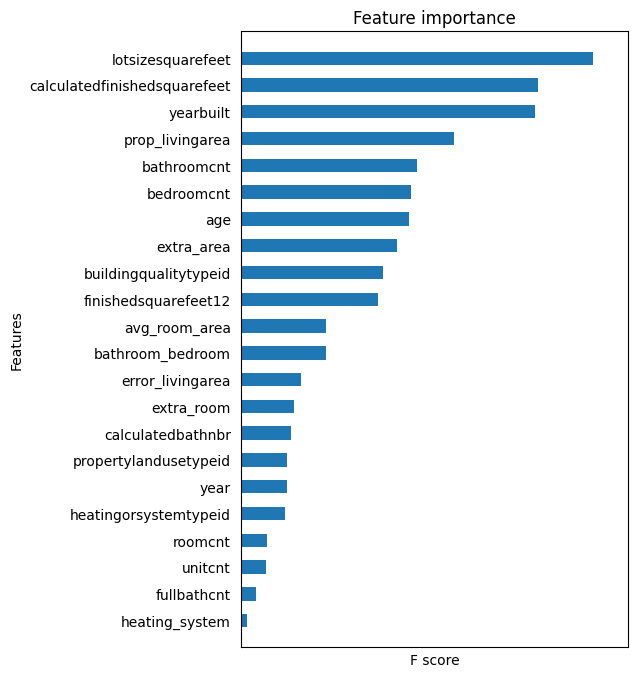

In [ ]:
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.5, ax=ax, show_values=False)
plt.grid(False)
plt.tick_params(left = False, bottom = False)
plt.xticks([])
plt.show()

# plt.figure(figsize=(5,8))
# xgb.plot_importance(xgb_model, max_num_features=50, height=0.7, show_values=False)
# plt.grid(False)
# plt.show()

In [ ]:
# sfs1 = SequentialFeatureSelector(LR(),
#                                  n_features_to_select=10,
#                                  direction='forward',
#                                  scoring='neg_mean_squared_error').fit(X_train, y_train)

In [ ]:
# sfs1.get_support()

In [ ]:
# sfs1.get_feature_names_out()

In [ ]:
cols = ['lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'yearbuilt',  'prop_livingarea', 'bathroomcnt',
        'age', 'bedroomcnt', 'extra_area', 'buildingqualitytypeid', 'finishedsquarefeet12']

In [ ]:
X = df_build_pd[cols]
y = df_build_pd['logerror']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Đánh giá mô hình
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.02724612320738126
Mean Absolute Error: 0.06915302523591084


In [ ]:
# tìm ra phương trình của mô hình
w = model.coef_
b = model.intercept_
print(f'y = {w}x + {b}')
print('Intercept of the model:',model.intercept_)
print('Coefficient of the line:',model.coef_)

y = [-3.27928283e-06 -6.56922232e-06  4.39742869e-03 -3.40155592e-03
 -3.14149474e-03  4.30015714e-03  3.24874445e-03  3.28993948e-06
 -5.32360337e-04  1.59375499e-05]x + -8.859724657872304
Intercept of the model: -8.859724657872304
Coefficient of the line: [-3.27928283e-06 -6.56922232e-06  4.39742869e-03 -3.40155592e-03
 -3.14149474e-03  4.30015714e-03  3.24874445e-03  3.28993948e-06
 -5.32360337e-04  1.59375499e-05]


In [ ]:
print(f'''y = {w[0]}*x1 + {w[1]}*x2 + {w[2]}*x3 + {w[3]}*x4 + {w[4]}*x5 + {w[5]}*x6 + {w[6]}*x7
        + {w[7]}*x8 + {w[8]}*x9 + {w[9]}*x10 + {b}''')

y = -3.2792828302033225e-06*x1 + -6.569222318001323e-06*x2 + 0.004397428693297468*x3 + -0.003401555916359984*x4 + -0.0031414947353536043*x5 + 0.004300157142497534*x6 + 0.00324874444685401*x7
        + 3.2899394752709394e-06*x8 + -0.0005323603367214458*x9 + 1.5937549915857734e-05*x10 + -8.859724657872304
